Notebook para auxiliar a execução do projeto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.animation as animation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

t_file = pd.read_csv('data/globalterrorismdb_0617dist.csv', encoding='ISO-8859-1')
t_file = t_file[np.isfinite(t_file.latitude)]
t_file.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


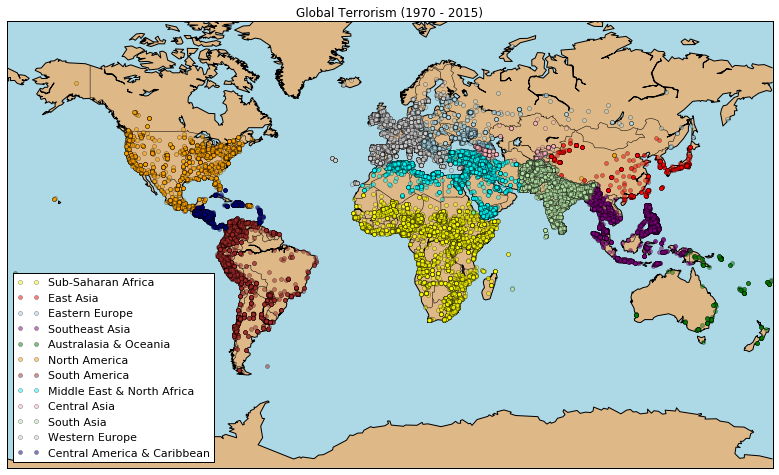

In [2]:
regions = list(set(t_file.region_txt))
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange', 'brown',\
          'aqua', 'lightpink', 'lightsage', 'lightgray', 'navy']

plt.figure(figsize=(15,8))
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='burlywood',lake_color='lightblue', zorder = 1)
m.drawmapboundary(fill_color='lightblue')

def pltpoints(region, color = None, label = None):
    x, y = m(list(t_file.longitude[t_file.region_txt == region].astype("float")),\
            (list(t_file.latitude[t_file.region_txt == region].astype("float"))))
    points = m.plot(x, y, "o", markersize = 4, color = color, label = label, alpha = .5)
    return(points)

for i, region in enumerate(regions):
    pltpoints(region, color = colors[i], label = region)  
    
plt.title("Global Terrorism (1970 - 2017)")
plt.legend(loc ='lower left', prop= {'size':11})
plt.show()    

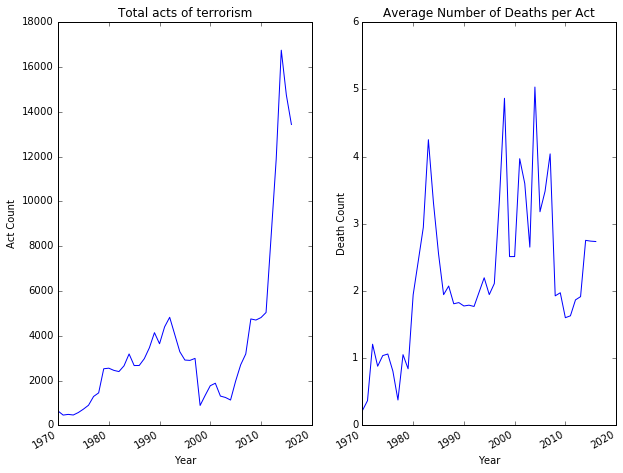

In [3]:
count_year = t_file.groupby(['iyear']).count() - 1
mean_year = t_file.groupby(['iyear']).mean()

fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set(title = 'Total acts of terrorism', ylabel = 'Act Count', xlabel = 'Year')
ax1.plot(count_year.index, count_year.eventid)
ax2.set(title = 'Average Number of Deaths per Act', ylabel = 'Death Count', xlabel = 'Year')
ax2.plot(mean_year.index, mean_year.nkill)
fig.autofmt_xdate()

In [4]:
region_mean_kills = []
for region in regions:
    region_mean_kills.append(t_file.nkill[t_file.region_txt == region].mean())

print('Average number of people killed per attack by Region\n')
for i, region in enumerate(regions):
    print('{}:{}'.format(region, round(region_mean_kills[i],2)))

Average number of people killed per attack by Region

Sub-Saharan Africa:4.98
East Asia:1.48
Eastern Europe:1.5
Southeast Asia:1.2
Australasia & Oceania:0.56
North America:1.47
South America:1.6
Middle East & North Africa:2.82
Central Asia:1.68
South Asia:2.28
Western Europe:0.43
Central America & Caribbean:3.37


In [5]:
import subprocess as sp

def mapmean(row):
    for i, region in enumerate(regions):
        return region_mean_kills[i]
    
t_file['region_mean'] = t_file.apply(mapmean, axis = 1)
t_file['nkill-mean'] = t_file['nkill'] - t_file['region_mean']
t_file['absnkill-mean'] = abs(t_file['nkill-mean'])

def get_points(year, region = regions):
    points = t_file[['iyear', 'latitude', 'longitude', 'nkill', 'region_mean', 'nkill-mean', 'absnkill-mean']][t_file.iyear == year]
    return(points)



In [16]:
fig = plt.figure(figsize=(10, 10))
fig.text(.8, .3, 'Bruno Santos https://github.com/brustrokes', ha='right')
fig.suptitle('Global Terrorism (1970 - 2015)')
cmap = plt.get_cmap('coolwarm')

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='burlywood',lake_color='lightblue', zorder = 1)
m.drawmapboundary(fill_color='lightblue')

START_YEAR = 1970
LAST_YEAR = 2015

points = get_points(START_YEAR)
x, y= m(list(points['longitude']), list(points['latitude']))
scat = m.scatter(x, y, s = points['absnkill-mean']*2, marker='o', alpha=0.3, zorder=10, c = points['nkill-mean'], cmap = cmap)
year_text = plt.text(-170, 80, str(START_YEAR),fontsize=15)
plt.close()

def update(frame_number):
    current_year = START_YEAR + (frame_number % (LAST_YEAR - START_YEAR + 1))
    points = get_points(current_year)
    color = list(points['nkill-mean'])
    x, y = m(list(points['longitude']), list(points['latitude']))
    scat.set_offsets(np.dstack((x, y)))
    scat.set_color(cmap(points['nkill-mean']))
    scat.set_sizes(points['absnkill-mean']*1.5)
    year_text.set_text(str(current_year))
    
ani = animation.FuncAnimation(fig, update, interval=750, frames=LAST_YEAR - START_YEAR + 1)
ani.save('animation.gif', writer='imagemagick', fps=2)


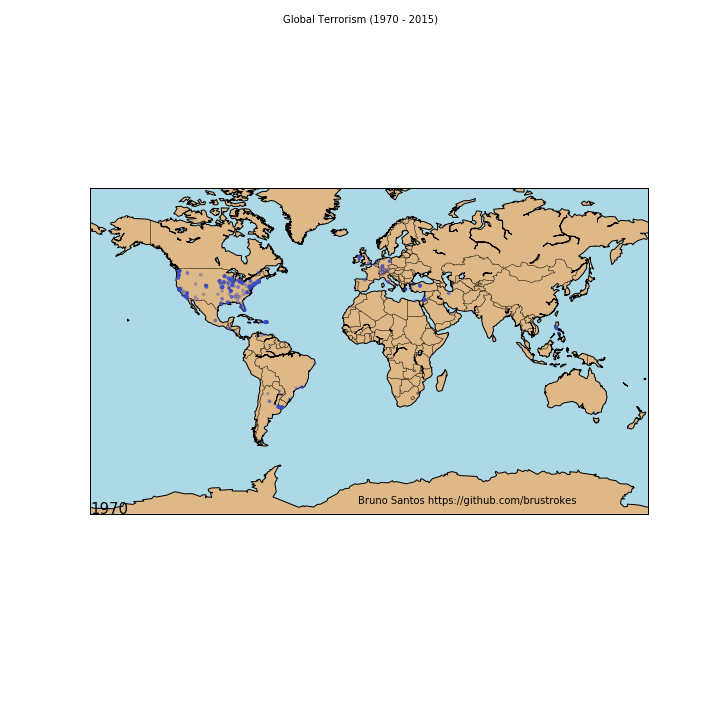

In [17]:
import io
import base64

filename = 'animation.gif'

video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

Agora vamos para o aprendizado de predição
Usando SGD e regressão linear para teste

In [124]:
#feature_cols = list(t_file.columns[:-1])
result_cols = [u'country']
feature_cols =  [u'country',u'iyear',u'imonth',u'iday',u'nkill']
full_date_cols =[u'iyear',u'imonth',u'iday']
full_date = t_file[full_date_cols]

X_all = t_file[feature_cols]
y_all = t_file[result_cols]
X_all = X_all.fillna(0)
print(full_date[:10])


   iyear  imonth  iday
0   1970       7     2
1   1970       0     0
2   1970       1     0
3   1970       1     0
4   1970       1     0
5   1970       1     1
6   1970       1     2
7   1970       1     2
8   1970       1     2
9   1970       1     3


In [116]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split  
# TODO: Set the number of training points
num_train = 100000 

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
##X_train = None
##X_test = None
##y_train = None
##y_test = None
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,  test_size = num_test, random_state=43,stratify=y_all)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of labels for any class cannot be less than 2.

In [111]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from time import time

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes',average=None)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: " + format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set:  " + format(predict_labels(clf, X_test, y_test))

In [71]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
from sklearn import svm
# from sklearn import model_B
from sklearn.linear_model import LogisticRegression
# from skearln import model_C
from sklearn import neighbors
from sklearn.metrics import f1_score

# TODO: Initialize the three models
clf_A = svm.SVC(random_state=40)
clf_B = LogisticRegression(random_state=42)
clf_C = neighbors.KNeighborsClassifier()

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

train_sets = [(X_train_100, y_train_100), (X_train_200, y_train_200), (X_train_300, y_train_300)]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
print("-----SVM-------")
for X, y in train_sets:
    train_predict(clf_A, X, y, X_test, y_test)
print("-----LogisticRegression-------")
for X, y in train_sets:
    train_predict(clf_B, X, y, X_test, y_test)
print("-----KNeighbors-------")
for X, y in train_sets:
    train_predict(clf_C, X, y, X_test, y_test)

-----SVM-------
Training a SVC using a training set size of 100. . .
Trained model in 0.0050 seconds
Made predictions in 0.0020 seconds.
F1 score for training set: [ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  0.92307692  0.96551724  1.          1.        ]
Made predictions in 0.7380 seconds.
F1 score for test set:  [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00197239  0.00204918  0.          0.
  0.          0.03156917  0.          0.00841751  0.          0.          0.
  0.00799087  0.          0.00153139  0.00172712  0.          0.06677524
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.00157978 

In [112]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

clfGNB = GaussianNB()
clfGNB.fit(X_train, y_train)
print(X_test)
predictions = clfGNB.predict(X_test)
print(clfGNB.predict([u'2017',u'2018']))
print (accuracy_score(y_test, predictions))



        country  iyear  imonth  iday  nkill
79857       185   2006       2    22    0.0
61607       182   1996       2    17    3.0
113689       95   2013       1    21    0.0
64546        69   1997       2     2    0.0
108100        4   2012       5    29    0.0
121794       92   2013      10     7    0.0
143909       60   2015       2     8    0.0
79767        95   2006       2    16    0.0
19396        61   1983       8     7    0.0
139920      153   2014      11     7    2.0
123497      147   2013      11    20    1.0
55949       155   1994       4    21    1.0
74094        92   2002       5    19    5.0
14414        30   1981      10     6    0.0
47640        92   1991       8    14    2.0
88481        95   2008       8    23    0.0
109514        4   2012       7    25    4.0
127046      147   2014       2    12    9.0
54978         6   1994       2     1    1.0
97688        95   2010       8    22    0.0
65056       110   1997       4     9    0.0
14938        61   1981      12  

E:\Users\brustrokes\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')